# The Image We Will Be Analysing


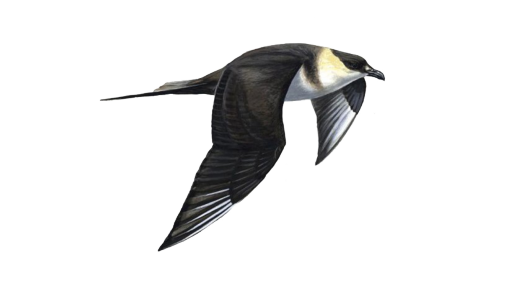

In [2]:
import matplotlib.pyplot as plt
image = plt.imread('image.png')
plt.axis('off')
plt.imshow(image)

# Get (r,g,b) pixel array from image


In [19]:
from PIL import Image
image = Image.open('image.jpg')
px = image.load()
print(image.size)  # Get the width and hight of the image for iterating over
print(px[50,100])

(999, 1024)
(112, 82, 9)


# K-Means clustering of images


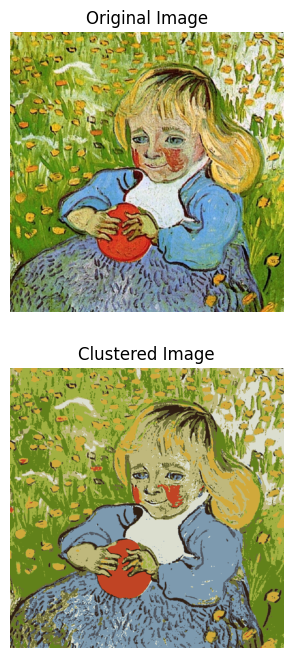

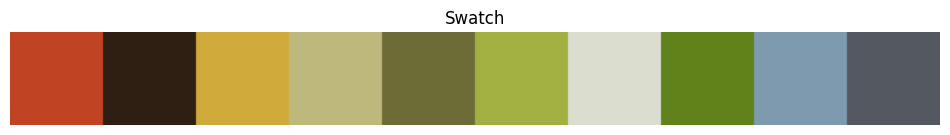

In [1]:

# ------------------------------------------------------------------------------
# Use k-means clustering to analyse colours in an image and produce a swatch of
# k colours. 
# ------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage import io, color
import colorspacious as cs

# ------------------------------------------------------------------------------
# Const 
# ------------------------------------------------------------------------------

SWATCH_HEIGHT = 50
SAMPLE_SIZE = 2000
RANDOM_STATE = 1
RBB_CHANNEL_MAX_VALUE = 255


# ------------------------------------------------------------------------------
# Utils 
# ------------------------------------------------------------------------------

def lab_to_lch(lab):
    """Convert a LAB color to LCH (Lightness, Chroma, Hue)."""
    return cs.cspace_convert(lab, "CIELab", "CIELCh")

def sort_by_hue(lab_colors):
    """Sort an array of LAB colors by their hue component."""
    lch_colors = [lab_to_lch(lab) for lab in lab_colors]
    # Extract hue values and sort by hue
    sorted_colors = sorted(lch_colors, key=lambda lch: lch[2])
    # Convert back to LAB
    return [cs.cspace_convert(lch, "CIELCh", "CIELab") for lch in sorted_colors]

def load_image(image_url):
    try:
        image = io.imread(image_url)
        # Normalize pixel values to [0, 1]
        return np.array(image, dtype=np.float64) / RBB_CHANNEL_MAX_VALUE
    except FileNotFoundError:
        raise FileNotFoundError(f"Image file not found at '{image_url}'") 


# ------------------------------------------------------------------------------
# Analysis 
# ------------------------------------------------------------------------------

def cluster_colors(image, n_colors):
    # Convert the image from RGB to LAB color space. LAB gives us a colour space
    # that better matches the way humans see colours. 
    image_lab = color.rgb2lab(image)

    # Reshape the image data from a nested to a flat array for processing
    w, h, d = image_lab.shape
    image_array = np.reshape(image_lab, (w * h, d))

    # Get a random sample of the image data (we don't need all of it to fit the
    # model and a sample is much faster)
    image_array_sample = shuffle(image_array, random_state=RANDOM_STATE)[:SAMPLE_SIZE]
    # Train the model using the sample data
    kmeans = KMeans(n_clusters=n_colors, random_state=RANDOM_STATE).fit(image_array_sample)
    # Use the model to assign all the pixels in the image to a cluster
    labels = kmeans.predict(image_array)
    
    return kmeans, labels, (w,h,d)

def analyse_image(image_url, n_colors):
    # Load the image
    original_image = load_image(image_url)

    # Cluster the colors using k-means
    kmeans, labels, whd = cluster_colors(original_image, n_colors)

    result = {
        'kmeans': kmeans,
        'labels': labels,
        'whd': whd,
    }
    
    return result


# ------------------------------------------------------------------------------
# Display 
# ------------------------------------------------------------------------------

# Use the clustered image data to create a new image, showing the colors
# quantised by their clusters.
def create_clustered_image(kmeans, labels, w,h,d):
    # Create a new image with the same shape as the original
    clustered_image_lab = np.zeros((w,h,d))
    label_idx = 0
    # Assign each pixel the color of the label it was assigned
    for i in range(w):
        for j in range(h):
            clustered_image_lab[i][j] = kmeans.cluster_centers_[labels[label_idx]]
            label_idx += 1
    # Convert the clustered image back from Lab to RGB color space
    return color.lab2rgb(clustered_image_lab)

def create_color_swatch(kmeans):
    lab_colours = kmeans.cluster_centers_
    lab_colors_sorted_by_hue = sort_by_hue(lab_colours)
    swatch = np.zeros((SWATCH_HEIGHT, len(lab_colors_sorted_by_hue) * SWATCH_HEIGHT, 3))
    for i, lab_color in enumerate(lab_colors_sorted_by_hue):
        # Convert the Lab color back to RGB for display
        rgb_color = color.lab2rgb(np.array([[lab_color]]))[0][0]
        swatch[:, i * SWATCH_HEIGHT:(i + 1) * SWATCH_HEIGHT, :] = rgb_color

    return swatch

# Display in Jupyter
def display(result): 
    original_image = load_image('image.jpg')
    # Generate a clustered version of the image
    clustered_image = create_clustered_image(result['kmeans'], result['labels'], *result['whd'])
    # Create a swatch to display the dominant colors
    swatch = create_color_swatch(result['kmeans'])
    
    # Display the original and clustered images
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(2, 1, 2)
    plt.title('Clustered Image')
    plt.imshow(clustered_image)
    plt.axis('off')

    plt.figure(figsize=(12, 2))
    plt.title('Swatch')
    plt.imshow(swatch)
    plt.axis('off')

    plt.show()
    
# ------------------------------------------------------------------------------
# Entry 
# ------------------------------------------------------------------------------

def init(image_url, n_colors=5):
    result = analyse_image(image_url, n_colors)
    display(result)
    
init('image.jpg', 10)